 - Deep Learning with Python - FRANÇOIS CHOLLET

    - Ch 5. Deep learning for computer vision
    
        - 5.3 Using a pretrained convnet

25 June 2023 - see lec 3 Q3 - Nasir hussain for more Details


kia hum numeric ya text data par bhi data augmentation lga sktay hain? isay explore krna, ye bht eham chhez hay



## 5.3.1 Feature extraction

See pg = 143 & so on for more details

Convolutional Base ki kuch layers ko lay lain gay (weights), on ko freeze kr dain gay, sirf classifier base ki layers ko train krain gay

"Representations found in densely connected layers no longer contain any information about
where objects are located in the input image: these layers get rid of the notion of space,
whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless"


Note that the level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the
model. Layers that come earlier in the model extract local, highly generic feature
maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as “cat ear” or “dog eye”). 
#### So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than
using the entire convolutional base.


In this case, because the ImageNet class set contains multiple dog and cat classes,
it’s likely to be beneficial to reuse the information contained in the densely connected
layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the
original model.



The VGG16 model, among others, comes prepackaged with Keras. You can import
it from the keras.applications module. Here’s the list of image-classification
models (all pretrained on the ImageNet dataset) that are available as part of keras
.applications:
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet


#### Listing 5.16: Instantiating the VGG16 convolutional base

In [1]:
from tensorflow.keras.applications import VGG16


In [2]:
# imagenet dataset ka naam hay, jis par VGG!^ model ko train kia gaya tha
conv_base = VGG16(weights      =  'imagenet',
                  include_top  =  False,
                  input_shape  =  (150, 150, 3))


You pass three arguments to the constructor:
- weights specifies the weight checkpoint from which to initialize the model.
- include_top refers to including (or not) the densely connected classifier on
top of the network. By default, this densely connected classifier corresponds to
the 1,000 classes from ImageNet. Because you intend to use your own densely
connected classifier (with only two classes: cat and dog), you don’t need to
include it.
- input_shape is the shape of the image tensors that you’ll feed to the network.
## This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

In [3]:
conv_base.summary()

# notice k picture ka size max-pooling k bad hi decrease hta hay, it means k padding lgai hui hay


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

#### Listing 5.17: Extracting features using the pretrained convolutional base

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


In [8]:

#see previous notebook for explanation
base_dir        =  r'C:\Users\Ans Imran\Desktop\PIAIC\Artificial Intelligence Engineering\Q3\Practice\Datasets\dogs-vs-cats\cats n dogs'
train_dir       =  os.path.join(base_dir, 'train')
validation_dir  =  os.path.join(base_dir, 'validation')
test_dir        =  os.path.join(base_dir, 'test')


#see previous notebook for explanation
datagen     =  ImageDataGenerator(rescale=1./255)
batch_size  =  20


In [8]:
#directory:     kis directory say data aaye ga, e.g: train, validation, test etc..
#sample_count:  kis directory main kitna data pra hay, sample count kitnay hain
def extract_features(directory, sample_count):

    features   =  np.zeros(shape=(sample_count, 4, 4, 512)) # 4d ZEROS matrix
# (sample_count, 4, 4, 512): see summary of conv base, ye asal main final feature map
# tha, conv base ki final layer ka output is shape ka hoga, so, ye shape hmaray liye, classifier base
# k liye input hogi, flatten krna h k ni aagay daikhain gay


    labels     =  np.zeros( shape=(sample_count) ) # har sample/pic k corresponding aik label 


    
# see previous notebook for explanation    
    generator  =  datagen.flow_from_directory(directory,
                    target_size  =  (150, 150),
                    batch_size   =  batch_size,
                    class_mode   =  'binary')
    

    
    i=0
    for inputs_batch, labels_batch in generator:
        
        features_batch = conv_base.predict(inputs_batch)
# edges etc ko mila k, jo cheezain bnay gi,on ko mila k jo new cheezain
# bnain gi, & so on, end main jo cheezain bnain gi, on ko return kray ga
# input batch k liye

# 20,20 images ka batch aaye ga, ye har har image k liye edges predict kr k return kr day ga
# ye converter hay   inputs_batch --> features_batch


# jo features batch pichli line nay bnaya tha, ye osay, 'features' k TENSOR main
# tarteeb say rkh day ga, aanay vlay batcjes, tarteeb-wise, is TENSOR main fit
# hotay jayain gay
# Note prof isay TENSOR ki bajaye CONTAINER keh rahay hain
        features[i*batch_size : (i+1)*batch_size]  =  features_batch


# labels sbhi tarteeb-wise fit hotay gaye 'labels-TENSOR' main    
        labels[  i*batch_size : (i+1)*batch_size]  =  labels_batch
        
        i += 1   # note k loop 'i' par ni chlai hui, so manually update krain gay
                 # furthermore, agar next iteration k liye data mojood nahi hay
                 # tmaam data processing ho chuki hui, tu is say next-line
                 # break kr day gi loop
        
        if i * batch_size >= sample_count:
            break
    return features, labels


In [10]:
train_features     , train_labels       = extract_features(train_dir     , 2000)
validation_features, validation_labels  = extract_features(validation_dir, 1000)
test_features      , test_labels        = extract_features(test_dir      , 1000)


Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 880ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 881ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step


Directly connecting kaggle to colab is possible, ask malik sahib


In [11]:
# The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them
# to a densely connected classifier, so first you must flatten them to (samples, 8192):

train_features       =  np.reshape(train_features      , (2000, 4*4* 512))
validation_features  =  np.reshape(validation_features , (1000, 4*4* 512))
test_features        =  np.reshape(test_features       , (1000, 4*4* 512))

# At this point, you can define your densely connected classifier (note
# the use of dropout for regularization) and train it on the data and
# labels that you just recorded


#### Listing: 5.18 Defining and training the densely connected classifier

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()


model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))   # see chapter 4 - for details. overfitting ho ri ho tu ye features drop kr deta hay, ye weights ko zero ni krta, weights, feautres predict krtay hain, but ye on mn say e.g yahan 50% drop kr day ga
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
                loss    = 'binary_crossentropy',
                metrics = ['acc'])


# yahan directly sirf generator ni day sktay thay, yahan just classifier layer hay, tu features conv_base say derive kr k hi pass
# krnay thay yahan
history = model.fit(train_features, train_labels,
            epochs           =  30,
            batch_size       =  20,
            validation_data  =  (validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.5722 - acc: 0.7050 - val_loss: 0.4196 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 0.4120 - acc: 0.8225 - val_loss: 0.3488 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3538 - acc: 0.8475 - val_loss: 0.3210 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2991 - acc: 0.8855 - val_loss: 0.2955 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2821 - acc: 0.8865 - val_loss: 0.2803 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2639 - acc: 0.8980 - val_loss: 0.2728 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2470 - acc: 0.8970 - val_loss: 0.2644 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

#### Listing 5.19: Plotting the results


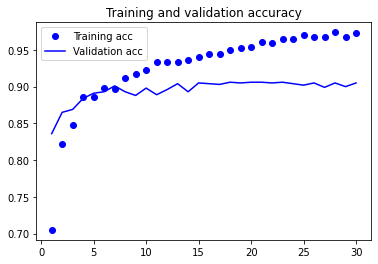

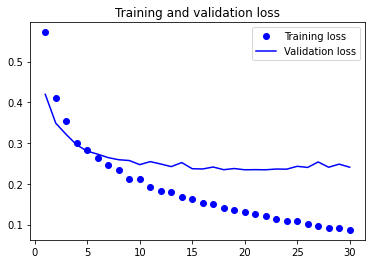

In [13]:
import matplotlib.pyplot as plt

acc      =  history.history['acc']
val_acc  =  history.history['val_acc']
loss     =  history.history['loss']
val_loss =  history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc    , 'bo',  label = 'Training acc')
plt.plot(epochs, val_acc, 'b' ,  label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss    , 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b' , label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### Plots also indicate that you’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.
